In [1]:
import numpy as np
import pandas as pd
from astropy.io import ascii
import os
import matplotlib.pyplot as plt
import mpl_scatter_density
import seaborn as sns
from sklearn.mixture import GaussianMixture

In [3]:
data = pd.read_csv('Catalogues/NGC2539_4.csv')
data

,RA_ICRS,DE_ICRS,Source,e_RA_ICRS,e_DE_ICRS,Plx,e_Plx,PM,pmRA,e_pmRA,...,RUWE,Gmag,BPmag,RPmag,BP-RP,RV,ELAT,RAJ2000,DEJ2000,Plx_corr
0,120.750245,-12.176855,3036167945540297216,0.0871,0.0647,0.8691,0.1415,3.414,-3.204,0.141,...,1.031,18.310925,19.155960,17.442314,1.713646,NaN,-31.849131,120.750260,-12.176860,0.893827
1,120.748502,-12.169048,3036168014259997824,0.3567,0.2588,0.8023,0.6067,2.525,-2.522,0.528,...,1.033,20.078209,20.758951,19.249168,1.509783,NaN,-31.841959,120.748514,-12.169048,0.798188
2,120.774801,-12.163916,3036173851116718848,0.2784,0.2068,0.7845,0.4647,2.086,-1.933,0.416,...,1.023,19.835163,20.270933,19.323252,0.947681,NaN,-31.830819,120.774810,-12.163912,0.797336
3,120.828863,-12.102368,3036174503951833984,0.3092,0.2460,0.6575,0.5399,2.136,-2.117,0.436,...,1.046,20.013603,20.620640,19.541338,1.079302,NaN,-31.758399,120.828872,-12.102367,0.665763
4,120.830799,-12.110140,3036174508246849152,0.3851,0.2784,0.8398,0.7343,4.241,-4.052,0.606,...,1.015,20.334070,21.634747,19.380322,2.254425,NaN,-31.765490,120.830818,-12.110146,0.819051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12248,122.595626,-10.841704,5728387720230650880,0.2191,0.2004,0.6737,0.3649,3.849,-3.663,0.338,...,1.022,19.428995,20.133577,18.738420,1.395157,NaN,-30.113705,122.595642,-10.841699,0.681967
12249,122.605064,-10.840512,5728387823309867136,0.2117,0.1868,0.5995,0.3435,1.575,-0.521,0.333,...,0.991,19.432290,19.966003,18.762100,1.203903,NaN,-30.110253,122.605066,-10.840505,0.614925
12250,122.441781,-10.867706,5728389644375975424,0.1436,0.1257,0.5921,0.2286,2.406,-2.406,0.236,...,1.031,18.805159,19.301994,18.132660,1.169334,NaN,-30.176260,122.441792,-10.867706,0.614038
12251,122.439955,-10.866530,5728389644376189952,0.1428,0.1257,0.6225,0.2265,2.891,-2.606,0.237,...,0.997,18.811468,19.214546,18.213182,1.001364,NaN,-30.175563,122.439967,-10.866535,0.644494


In [9]:
df1 = data[["RAJ2000", "DEJ2000", "pmRA", "pmDE", "BP-RP", "Plx"]].copy()

# Matriz de Correlação das Features

Isso ajuda a identificar se algumas features são redundantes (exemplo: se pmra e pmdec forem altamente correlacionadas, talvez uma delas possa ser descartada).

In [10]:
#correlação de Pearson. já é invariante, não precisa normalizar
corr_matrix = df1.corr()

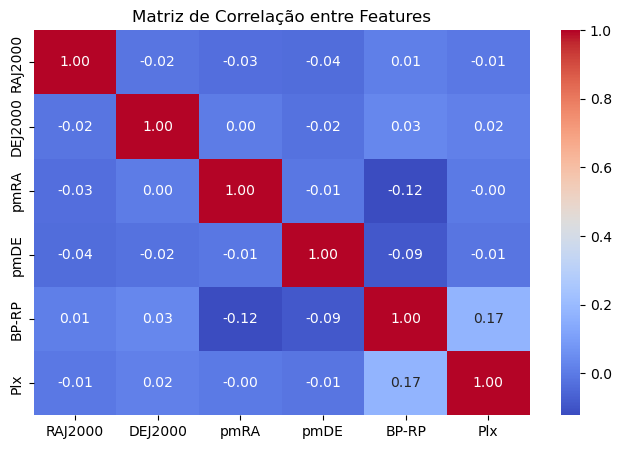

In [11]:
plt.figure(figsize=(8,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação entre Features")
plt.show()

# PCA - Análise das Componentes Principais

Vai nos ajudar a entender:

- Quantas dimensões realmente precisamos?
- Se algumas features contribuem pouco e podem ser descartadas.



## Precisei retirar linhas com valor NaN pra rodar o PCA

Estimei a quantidade de linhas com esses valores pra saber se não estava perdendo muitos objetos.

In [19]:
len(df1)

12253

In [17]:
# Contar quantas linhas têm pelo menos um NaN nas colunas selecionadas
nan_rows = df1.isna().sum(axis=1) > 0
num_nan_rows = nan_rows.sum()

# Exibir o número total de linhas com NaN
print(f"Linhas com pelo menos um NaN: {num_nan_rows}")

Linhas com pelo menos um NaN: 125


In [20]:
# Verificar a porcentagem de dados ausentes por feature
nan_percentage = df1.isna().mean() * 100
print(f"Porcentagem de NaN por feature:\n{nan_percentage}")

Porcentagem de NaN por feature:
RAJ2000    0.000000
DEJ2000    0.000000
pmRA       0.000000
pmDE       0.000000
BP-RP      1.020158
Plx        0.000000
dtype: float64


In [22]:
# Remover linhas com NaN
df1_clean = df1.dropna()

## Continuando...

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [23]:
X = df1_clean.values

In [24]:
# Normalizar os dados (PCA é sensível à escala!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [27]:
# Aplicar PCA
n_components = 6
pca = PCA(n_components=n_components)  # Criamos tantos componentes quanto features temos
pca.fit(X_scaled)

PCA(n_components=6)

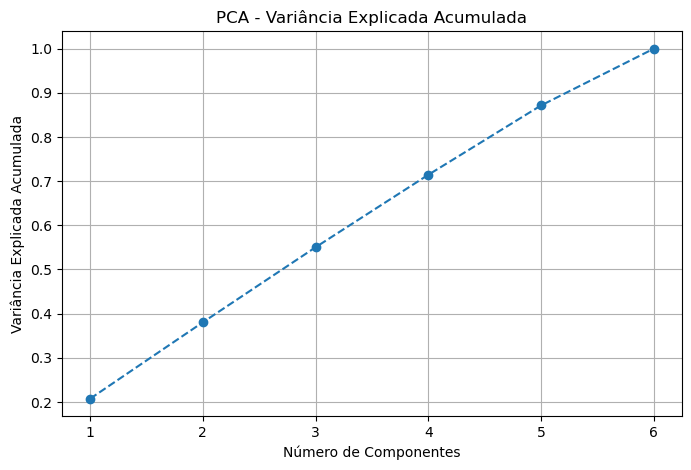

In [28]:
# Plotando a variância explicada acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel("Número de Componentes")
plt.ylabel("Variância Explicada Acumulada")
plt.title("PCA - Variância Explicada Acumulada")
plt.grid()
plt.show()

Mostra a quantidade acumulada de variância explicada pelos componentes principais, expressa como uma porcentagem. A soma das variâncias de todos os componentes principais será 100%.
Vemos no gráfico que com 5 componentes já atingimos quase 90% de Variância Explicada, o que nos permite representar bem os dados e ainda diminuir as dimensões. A perda de informação será pequena (apenas 10%).


# Random Forest - Análise da Importância das Features

In [29]:
from sklearn.ensemble import RandomForestClassifier

## Rótolus aleatórios

In [32]:
# Gerando rótulos fictícios aleatórios (aqui com 3 classes, mas pode ser ajustado)
np.random.seed(42)
n_samples = len(df1_clean)  # Quantidade de dados
fake_labels = np.random.randint(0, 3, size=n_samples)  # Rótulos aleatórios (0, 1, 2)

# Adicionando ao DataFrame
df1_clean.loc[:, 'Cluster'] = fake_labels

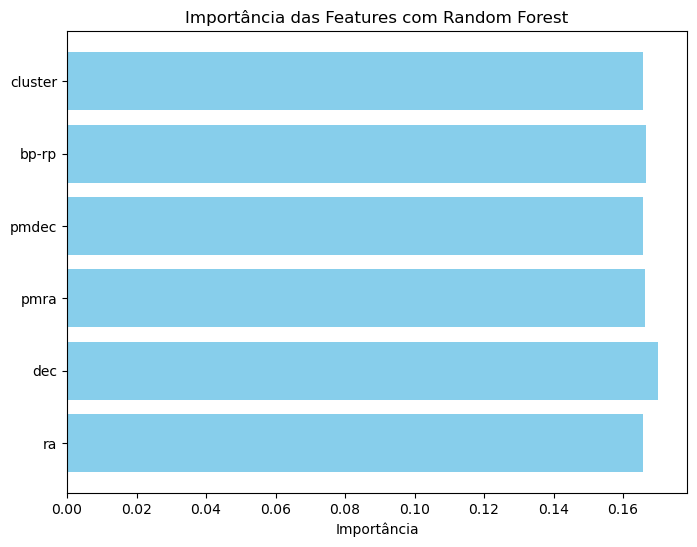

In [39]:
# Definir as features e o target (rótulos fictícios gerados acima)
X = X_scaled  # ou as features originais
y = df1_clean['Cluster']  # rótulos fictícios

# Treinando o modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# features
features = features = ['ra', 'dec', 'pmra', 'pmdec', 'bp-rp', 'cluster'] 
# Importância das features
importances = rf.feature_importances_

# Plotando a importância das features
plt.figure(figsize=(8, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importância')
plt.title('Importância das Features com Random Forest')
plt.show()

## Aplicando clusterização antes de avaliar a importância das features

In [40]:
from sklearn.cluster import KMeans

### Primeiro analisamos a quantidade ideal de clusters

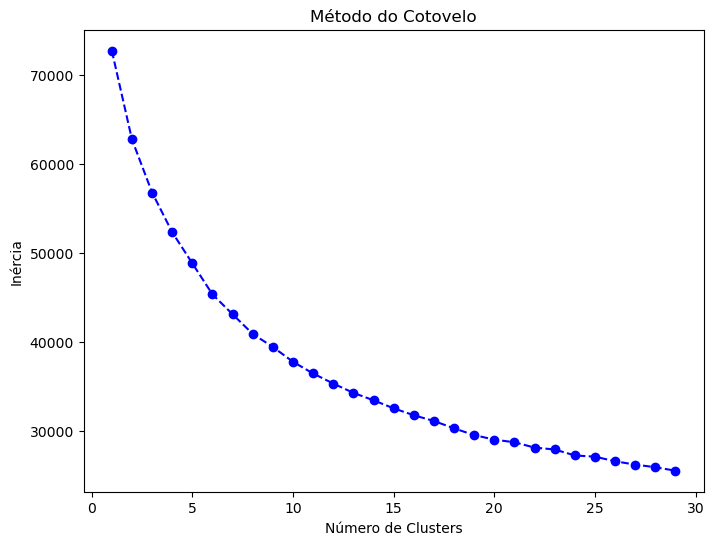

In [47]:
# Testando diferentes números de clusters (de 1 a 10, por exemplo)
inertia = []  # armazena a soma das distâncias quadráticas (inertia)

for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)  # Usando X_scaled ou os dados com PCA se preferir
    inertia.append(kmeans.inertia_)

# Plotando o gráfico do método do cotovelo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 30), inertia, marker='o', linestyle='--', color='b')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.show()

A inércia (ou "within-cluster sum of squares") é uma métrica usada para avaliar a qualidade de um agrupamento em K-Means.

Ela mede a soma das distâncias quadráticas entre cada ponto de dados e o centroide do seu respectivo cluster. Em outras palavras:

Baixa inércia significa que os pontos dentro de cada cluster estão próximos do centroide (indica que o cluster é bem formado e compacto).
Alta inércia indica que os pontos estão mais espalhados e distantes do centroide, o que sugere clusters mais fracos e menos coesos.

Visualmente a inércia começa a diminuir mais lentamente em k=4-6.

### Agora aplicamos o KMeans

In [51]:
# Aplicando o K-Means com 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)  # Aplicando o K-Means e prevendo os clusters

# Adicionando os clusters ao DataFrame
df1_clean.loc[:, 'Cluster'] = clusters

In [52]:
# Verificando a distribuição dos clusters
print(df1_clean['Cluster'].value_counts())

Cluster
3    2691
2    2502
0    2458
4    2239
1    2238
Name: count, dtype: int64


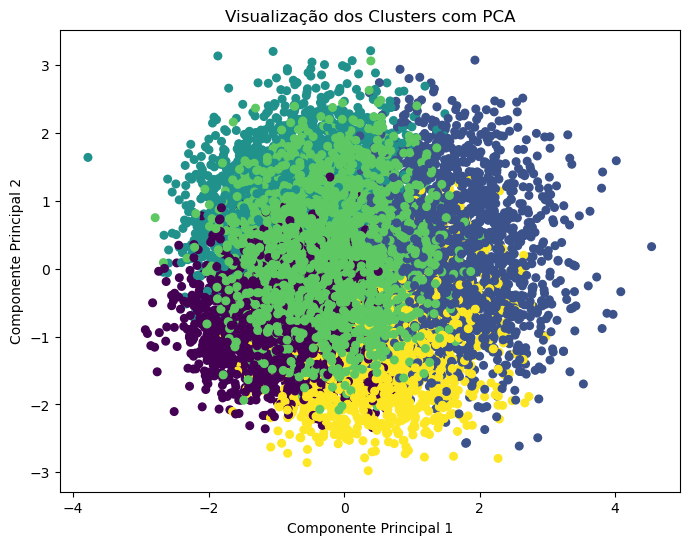

In [55]:
# Visualizando os clusters (usando PCA com 2 componentes, por exemplo)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=df1_clean['Cluster'], cmap='viridis', s=30)
plt.title('Visualização dos Clusters com PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

In [56]:
# Verificando a média das features por cluster
print(df1_clean.groupby('Cluster').mean())

            RAJ2000    DEJ2000      pmRA      pmDE     BP-RP       Plx
Cluster                                                               
0        121.503182 -12.557972 -1.841082  0.088941  1.121088  0.647980
1        122.640902 -12.806153 -2.642474 -1.043478  1.754594  0.737544
2        123.009461 -13.890533 -2.138392  0.216227  1.150988  0.658827
3        123.290983 -12.116541 -1.965230 -0.241939  1.051030  0.705148
4        122.099789 -12.980856 -1.829324  0.396089  1.350161  0.817228


In [57]:
# Identificando outliers para cada cluster (exemplo: usando 1.5 vezes o IQR)
for cluster in df1_clean['Cluster'].unique():
    cluster_data = df1_clean[df1_clean['Cluster'] == cluster]
    Q1 = cluster_data.quantile(0.25)
    Q3 = cluster_data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = cluster_data[(cluster_data < (Q1 - 1.5 * IQR)) | (cluster_data > (Q3 + 1.5 * IQR))]
    print(f"Outliers no Cluster {cluster}:")
    print(outliers)

Outliers no Cluster 4:
       RAJ2000  DEJ2000  pmRA  pmDE  BP-RP  Plx  Cluster
0          NaN      NaN   NaN   NaN    NaN  NaN      NaN
1          NaN      NaN   NaN   NaN    NaN  NaN      NaN
4          NaN      NaN   NaN   NaN    NaN  NaN      NaN
10         NaN      NaN   NaN   NaN    NaN  NaN      NaN
14         NaN      NaN   NaN   NaN    NaN  NaN      NaN
...        ...      ...   ...   ...    ...  ...      ...
12157      NaN      NaN   NaN   NaN    NaN  NaN      NaN
12190      NaN      NaN   NaN   NaN    NaN  NaN      NaN
12201      NaN      NaN   NaN   NaN    NaN  NaN      NaN
12216      NaN      NaN   NaN   NaN    NaN  NaN      NaN
12245      NaN      NaN   NaN   NaN    NaN  NaN      NaN

[2239 rows x 7 columns]
Outliers no Cluster 0:
       RAJ2000  DEJ2000  pmRA  pmDE     BP-RP  Plx  Cluster
2          NaN      NaN   NaN   NaN       NaN  NaN      NaN
3          NaN      NaN   NaN   NaN       NaN  NaN      NaN
5          NaN      NaN   NaN   NaN       NaN  NaN      NaN
6    

## Rótulos do Kmeans


In [58]:
from sklearn.model_selection import train_test_split

In [59]:
# Definindo as variáveis: X (features) e y (clusters gerados pelo KMeans)
X = df1_clean.drop(columns=['Cluster'])  # Removendo a coluna de clusters do DataFrame
y = df1_clean['Cluster']  # Rótulos de clusters gerados

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Inicializando o Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Treinando o modelo
rf.fit(X_train, y_train)

# Obtendo a importância das features
feature_importances = pd.DataFrame(rf.feature_importances_, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)

# Mostrando as features mais importantes
print(feature_importances)


         Importance
RAJ2000    0.221992
DEJ2000    0.216240
Plx        0.213487
BP-RP      0.156799
pmDE       0.123837
pmRA       0.067645


<Figure size 1000x600 with 0 Axes>

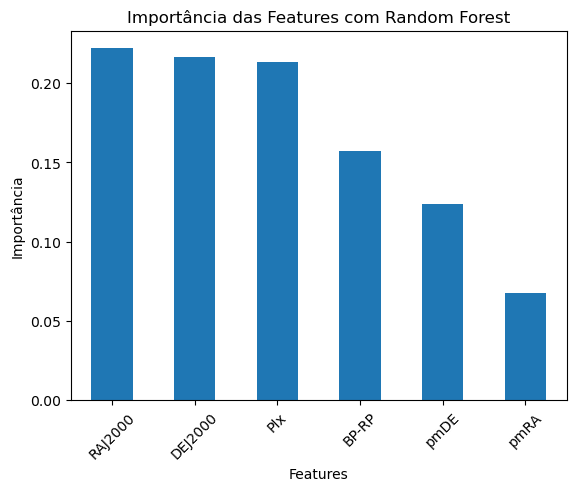

In [60]:
# Criando o gráfico de barras para a importância das features
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar', legend=False)
plt.title('Importância das Features com Random Forest')
plt.xlabel('Features')
plt.ylabel('Importância')
plt.xticks(rotation=45)
plt.show()

# t-SNE - Análise da importância das features

In [62]:
from sklearn.manifold import TSNE

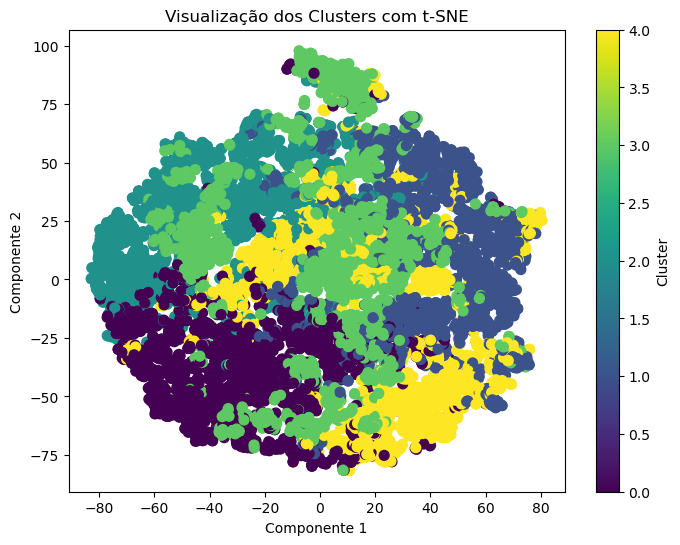

In [63]:
# Aplicando o t-SNE para reduzir para 2 componentes
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(X_scaled)  # Usando os dados escalados

# Plotando os resultados
plt.figure(figsize=(8, 6))
plt.scatter(tsne_components[:, 0], tsne_components[:, 1], c=df1_clean['Cluster'], cmap='viridis', s=50)
plt.title('Visualização dos Clusters com t-SNE')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.colorbar(label='Cluster')
plt.show()

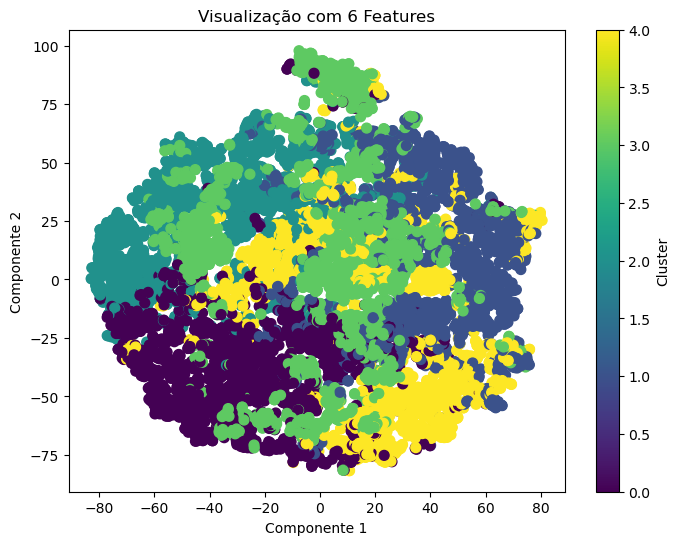

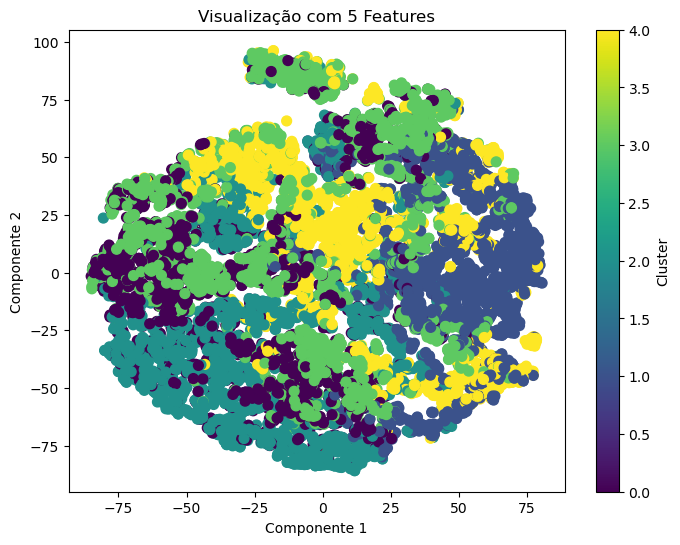

In [69]:
# Vamos criar uma função para aplicar o t-SNE com diferentes subconjuntos de features
def plot_tsne_with_features(features_to_use):
    # Selecionando as features para o t-SNE
    X_tsne = df1_clean[features_to_use]
    
    # Escalando os dados
    X_scaled_tsne = scaler.fit_transform(X_tsne)
    
    # Aplicando o t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_components = tsne.fit_transform(X_scaled_tsne)
    
    # Plotando os resultados
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_components[:, 0], tsne_components[:, 1], c=df1_clean['Cluster'], cmap='viridis', s=50)
    plt.title(f'Visualização com {len(features_to_use)} Features')
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.colorbar(label='Cluster')
    plt.show()

# Exemplo: Aplicando t-SNE com todas as features
plot_tsne_with_features(df1_clean.drop(columns=['Cluster']).columns)

# Exemplo: Aplicando t-SNE sem a feature 'ra'
plot_tsne_with_features(df1_clean.drop(columns=['Cluster', 'RAJ2000']).columns)

# Exemplo: Aplicando t-SNE sem a feature 'ra'
#plot_tsne_with_features(df1_clean.drop(columns=['Cluster', 'RAJ2000', 'DEJ2000']).columns)